In [1]:
# %matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)
# reflect the tables

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# Example:
calc_temps('2017-08-01','2017-08-07')

[(72.0, 79.25, 83.0)]

In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
start_date = '2017-08-01'
end_date = '2017-08-07'
trip_temp = pd.DataFrame(calc_temps(start_date,end_date),columns=['TMIN','TAVE','TMAX'])
trip_temp

,TMIN,TAVE,TMAX
0,72.0,79.25,83.0


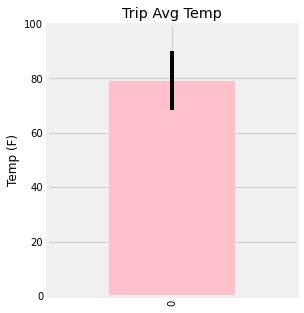

In [11]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
peak_to_peak = trip_temp.TMAX-trip_temp.TMIN
trip_temp.TAVE.plot(kind='bar',color='pink',figsize=(4,5),title='Trip Avg Temp',yerr = peak_to_peak)
plt.ylim(0,100)
plt.ylabel('Temp (F)')
plt.savefig('images/temperature.png')
plt.show()

### Daily Rainfall Average

In [12]:
# Calculate the rainfall per weather station using the previous year's matching dates.
# Sort this in descending order by precipitation amount
# Joint with Station data

prcp_total = func.sum(Measurement.prcp)
rainfall_per_station = session.query(Measurement.station,prcp_total,Station.name,Station.latitude, Station.longitude,Station.elevation).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.station).order_by(prcp_total.desc()).filter(Measurement.station==Station.station).all()

#  Create Dataframe and list the station, name, latitude, longitude, and elevation.
rainfall_per_station_df = pd.DataFrame(rainfall_per_station,columns=['station', 'prcp', 'name', 'latitude', 'longitude','elevation'])
rainfall_per_station_df

,station,prcp,name,latitude,longitude,elevation
0,USC00516128,0.36,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,USC00514830,0.22,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
2,USC00519281,0.06,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
3,USC00519397,0.04,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
4,USC00519523,0.00,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5


In [13]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals('08-07')

[(71.0, 77.15686274509804, 83.0)]

In [14]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
travel_start = '2018-08-01'
travel_end = '2018-08-07'
travel_start_date = dt.date(int(travel_start.split('-')[0]),int(travel_start.split('-')[1]),int(travel_start.split('-')[2]))
travel_end_date = dt.date(int(travel_end.split('-')[0]),int(travel_end.split('-')[1]),int(travel_end.split('-')[2]))

numdays = travel_end_date-travel_start_date

# Use the start and end date to create a range of dates
travel_day_list = [travel_end_date - dt.timedelta(days=x) for x in range(7)]


# Strip off the year and save a list of strings in the format %m-%d
travel_month_day = [d.strftime("%m-%d") for d in travel_day_list]
travel_month_day

['08-07', '08-06', '08-05', '08-04', '08-03', '08-02', '08-01']

In [15]:
# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals = [daily_normals(d) for d in travel_month_day]
normals

[[(71.0, 77.15686274509804, 83.0)],
 [(67.0, 76.25, 83.0)],
 [(69.0, 76.14814814814815, 82.0)],
 [(69.0, 76.71153846153847, 84.0)],
 [(70.0, 76.61111111111111, 85.0)],
 [(68.0, 75.60377358490567, 84.0)],
 [(67.0, 75.54, 83.0)]]

In [16]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_rows = [{"TMIN": normal[0][0],"TAVE": normal[0][1],"TMAX": normal[0][2]} for normal in normals]
normals_travel = pd.DataFrame(normals_rows,columns=['TMIN','TAVE','TMAX'])
normals_travel['Trip Date'] = travel_day_list
normals_travel = normals_travel.set_index(['Trip Date'])
normals_travel

,TMIN,TAVE,TMAX
Trip Date,,,
2018-08-07,71.0,77.156863,83.0
2018-08-06,67.0,76.250000,83.0
2018-08-05,69.0,76.148148,82.0
2018-08-04,69.0,76.711538,84.0
2018-08-03,70.0,76.611111,85.0
2018-08-02,68.0,75.603774,84.0
2018-08-01,67.0,75.540000,83.0


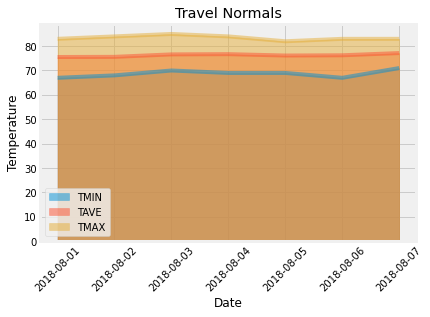

In [17]:
# Plot the daily normals as an area plot with `stacked=False`
normals_travel.plot.area(stacked=False, title = "Travel Normals")
plt.xticks(rotation=45)
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.savefig('images/daily-normals.png')
plt.show()

## Close Session

In [18]:
session.close()